## Calculate speckle contrast factor

Import required modules

In [1]:
import numpy as np
from sympy import (symbols, Integral, integrate, cos, sin, cot, 
                   Eq, lambdify, exp, pi, Abs)

from scipy.integrate import quad, dblquad

from collections import OrderedDict

from sympy import init_printing

from IPython.display import display, Latex, Image
init_printing()

In [2]:
from sympy.printing import latex

Parameters
-----------
$\xi_h$   : Horizontal x-ray coherence length [$\mu$m]

$\xi_v$   : Vertical x-ray coherence length [$\mu$m]

$r$       : longitudinal x-ray coherence length in terms
          of $\Delta \lambda / \lambda$ [dimensionless]

$M$       : Vertical height of pinhole [$\mu$m]

$L$       : Horizontal width of pinhole [$\mu$m]

$W$       : X-ray penetration depth [$\mu$m]

$\theta$  : Half x-ray scattering angle [rad]

$\theta_i$: Incident x-ray scattering angle [rad]

$k_0$     : X-ray wavenumber [$\mu$m$^{-1}$]

## Calculate lambda and two theta of reflection

In [3]:
E = 855 #eV
a = 3.8 #ang
lam = 1.2398e4/E
two_theta = 2*np.arcsin(lam * np.sqrt(3) / (2*4*a))      
Latex(r"""
$$E = {:.1f}~\mathrm{{eV}}$$
$$a = {:.3f}~\mathring A$$
$$\lambda = {:.3f}~\mathring A$$
$$2\theta = {:.1f}^o$$
""".format(E, a, lam, two_theta*180/np.pi))


<IPython.core.display.Latex object>

## Calculate angle between incident beam and sample

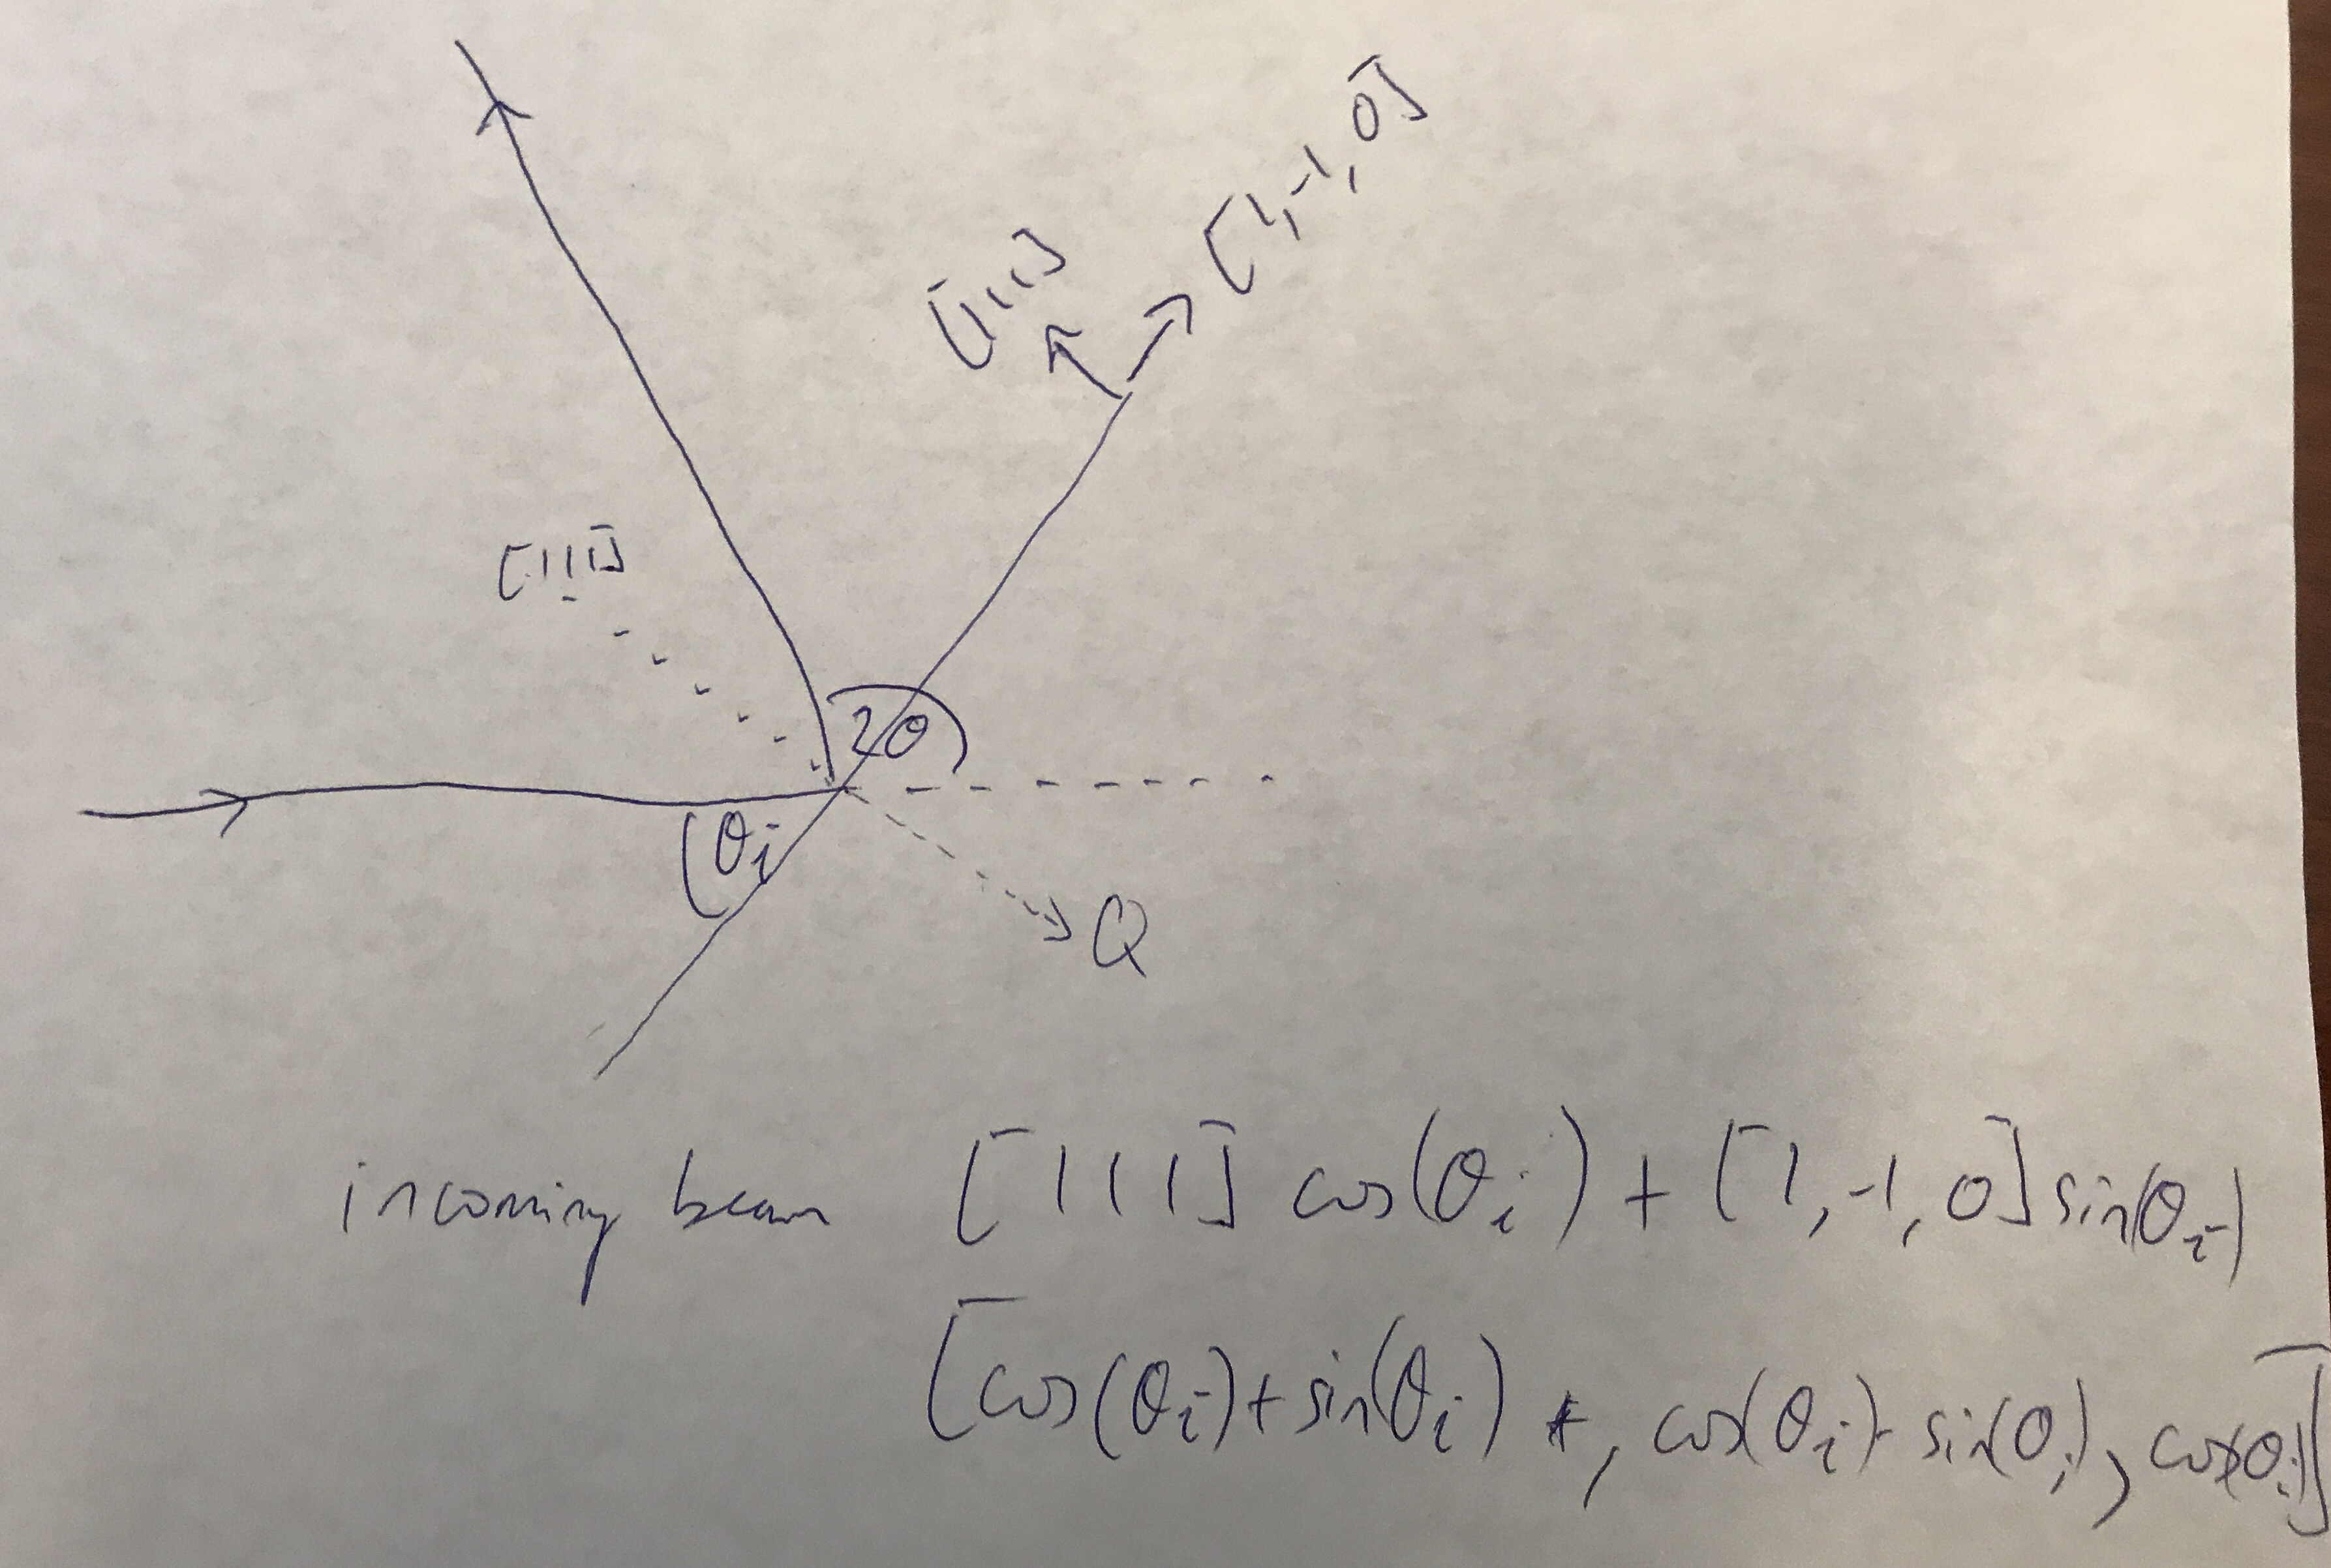

In [4]:
Image('nickelates_sketch.jpg')

In [5]:
ti = two_theta/2
n = np.array([1, 1, 1])
i = np.array([np.cos(ti) + np.sin(ti), np.cos(ti) - np.sin(ti), np.cos(ti)])

def norm(v):
    return np.sum(v**2)**0.5

sin_ang = np.dot(i, n) / (norm(i)*norm(n))
surface_ang = np.arcsin(sin_ang)
L = a*50/np.cos(surface_ang) * 1e-4 
Latex("{:.5f} microns".format(L))
Latex("""Surface angle is {:.1f}$^o$.
So the beam goes {:.5f} microns through the sample.
""".format(surface_ang*180/np.pi, L))

<IPython.core.display.Latex object>

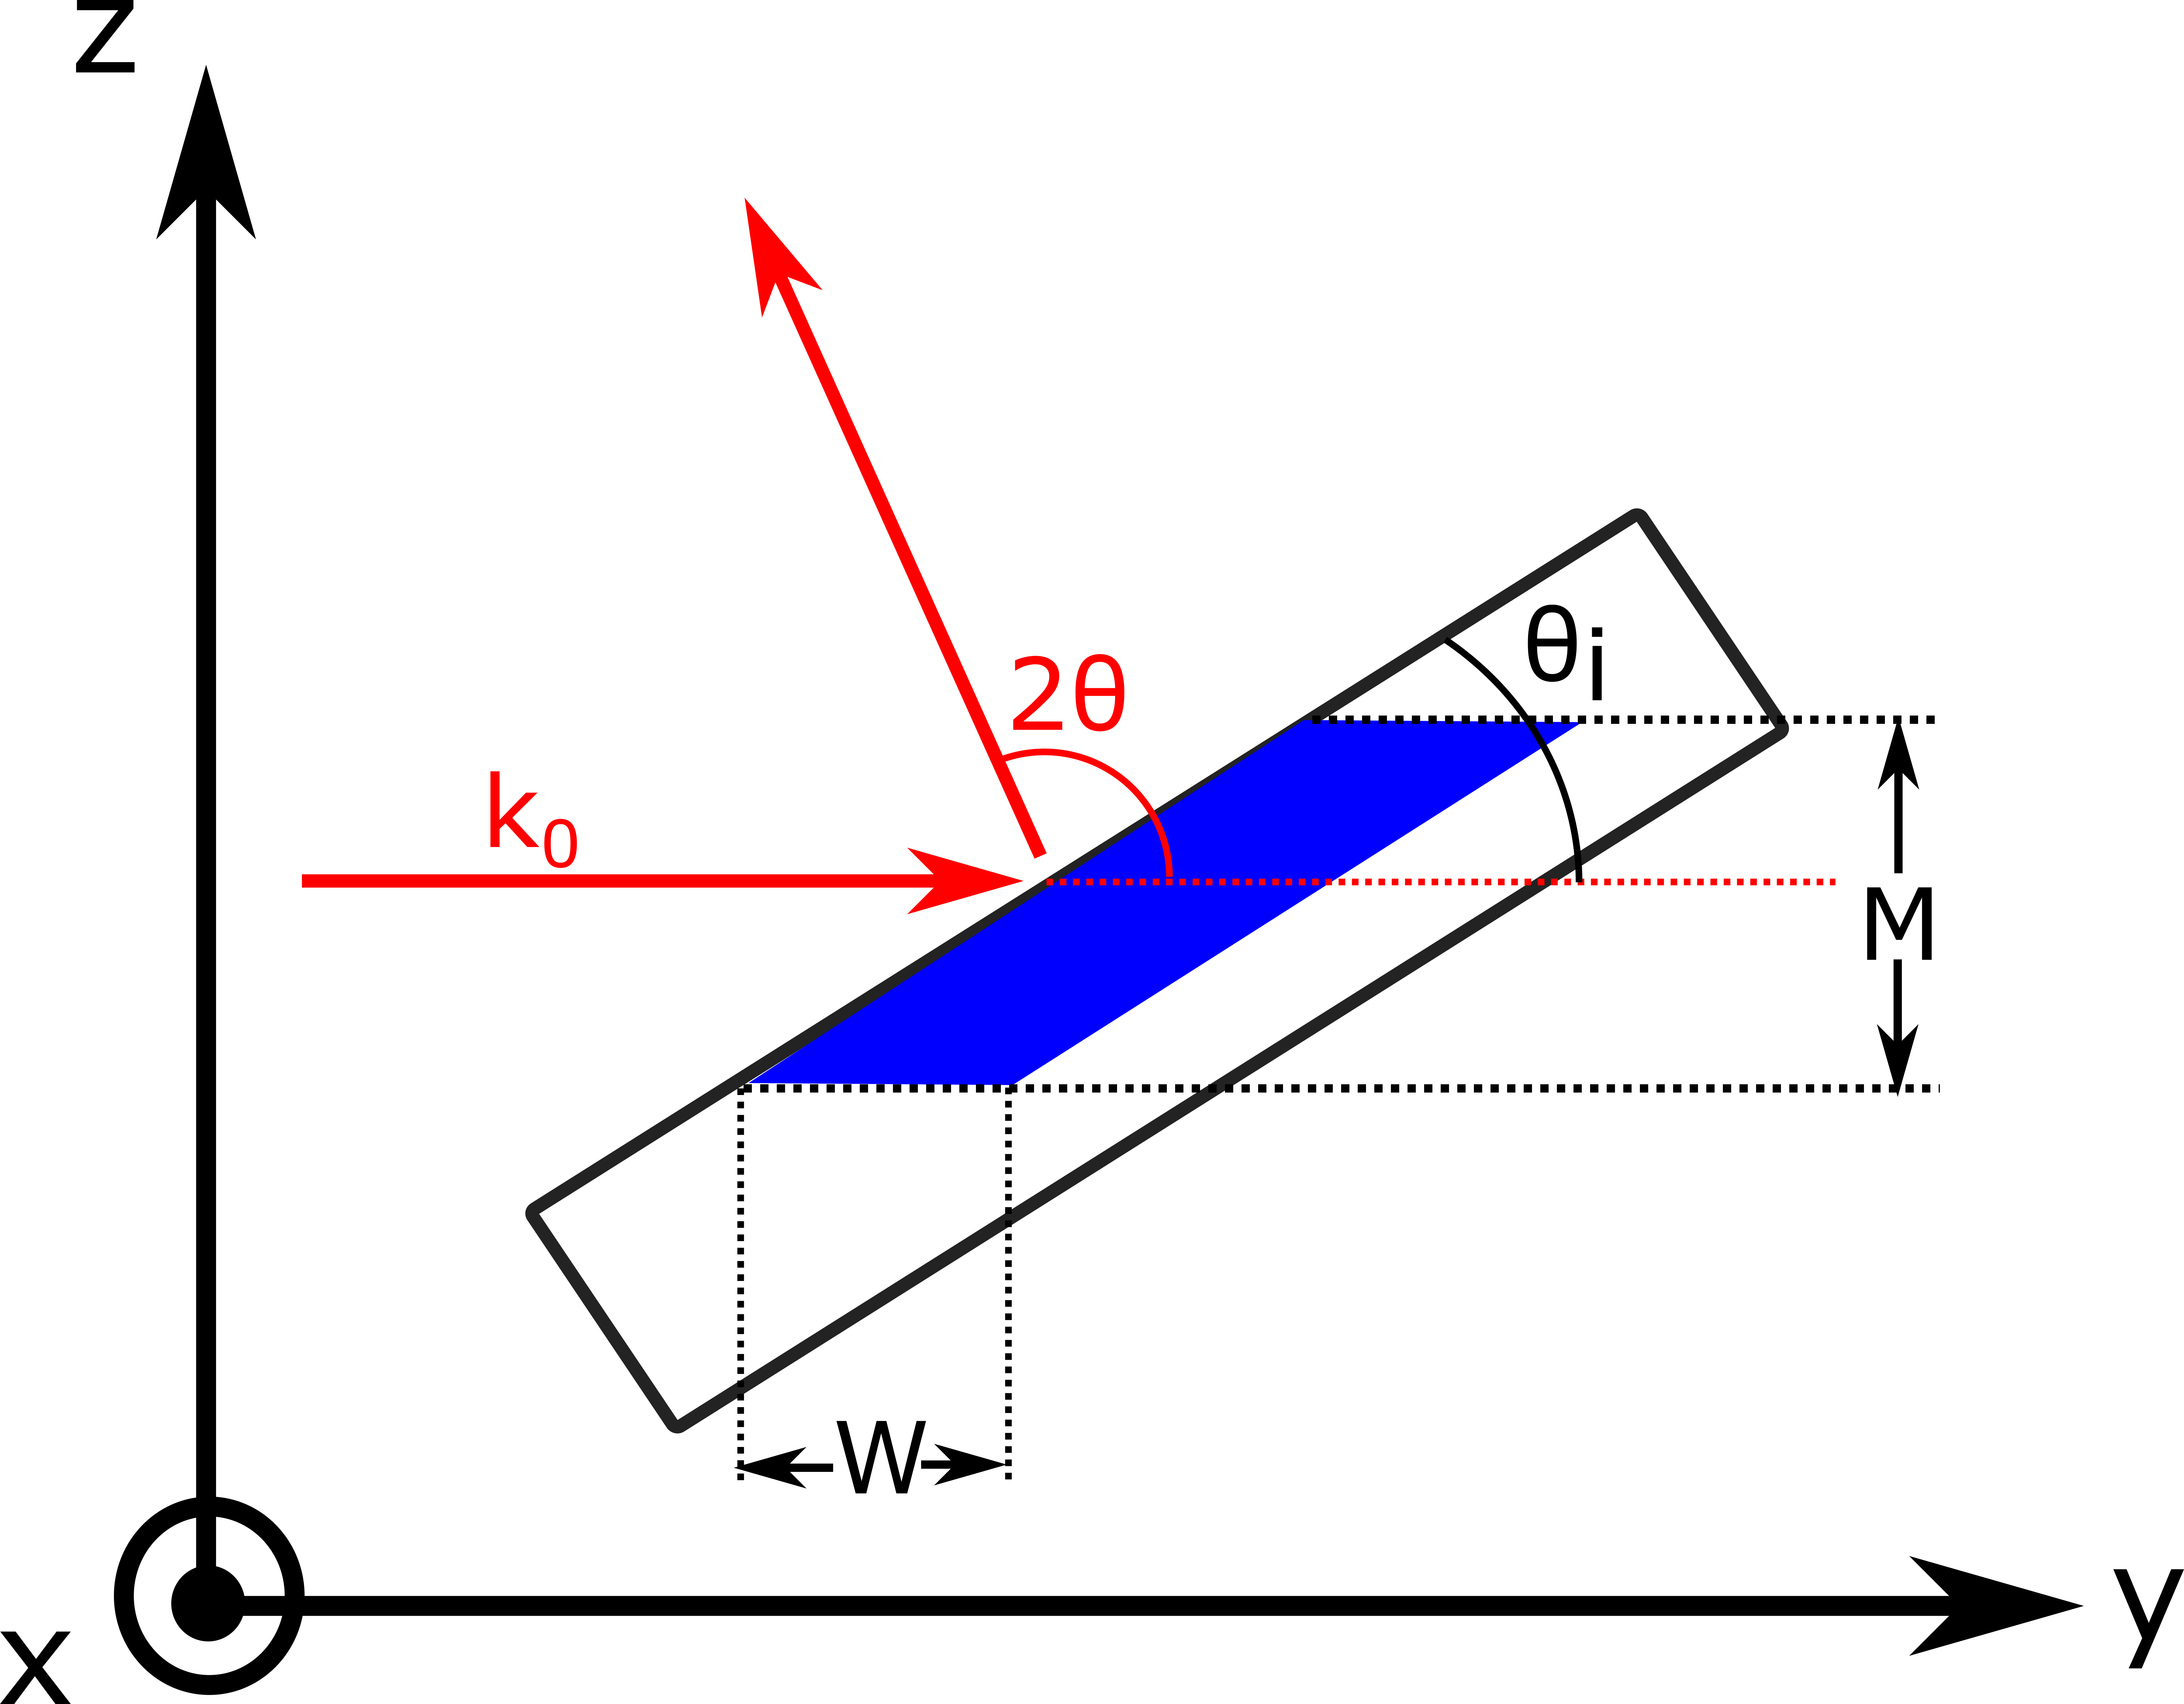

In [6]:
Image(filename=('../Fig_S1_Geometry.png'))

X-rays with wavevector $k_0$ are incident on the sample at angle $\theta_i$ and are scattered through angle $2\theta$. The projections of the illuminated sample volume (shown in blue) along the $y$ and $z$ axes are $W$ and $M$, respectively.

In [7]:
values_dict = OrderedDict(xi_h=10,
                          xi_v=10,
                          r=1/1900,
                          M=10,
                          L=L,
                          W=0.15, 
                          theta=(two_theta/2)*(pi/180),
                          theta_i=two_theta/2*pi/180,
                          k_0=2*pi/(lam * 1e-4))

Speckle contrast factor, $\beta$ is composed of a vertical and radial components $\beta_z$ and $\beta_r$.

$\beta_z$ is

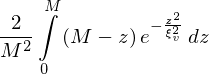

In [8]:
k_0, r, theta, theta_i, beta_z = symbols('k_0 r theta theta_i beta_z')
M, z, xi_v = symbols('M z xi_v')
beta_z = 2 / M**2 * Integral( (M-z) * exp(-z**2/xi_v**2) , (z, 0 , M))
beta_z

In [9]:
beta_z_val = beta_z.subs(values_dict).doit().evalf()
print("Which evaluates to {:.6f} .".format(beta_z_val))

Which evaluates to 0.861528 .


$\beta_r$ is

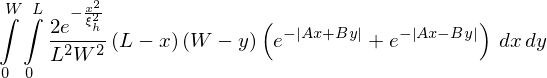

In [10]:
A, B, beta_r = symbols('A B beta_r')
L, W, x, y, xi_h = symbols('L W x y xi_h')
integrand = 2 / (W**2  * L**2) * (L-x) * (W-y) * exp(-x**2/xi_h**2) * (exp(-Abs(A*x + B*y)) + exp(-Abs(A*x - B*y)))
beta_r = Integral(integrand, (x, 0, L), (y, 0, W))
beta_r

This depends on parameters $A$ and $B$

In [11]:
Atosub = 4 * k_0 * r * (cos(theta)*sin(theta) - sin(theta)**2 * cot(theta_i))
Atosub

In [12]:
Btosub = -4*k_0* r * sin(theta)**2
Btosub

Evaluating $\beta_r$ gives

In [13]:
full_integrand = integrand.subs({A:Atosub, B:Btosub}).subs(values_dict)
f_integrand = lambdify((x, y), full_integrand)

L = values_dict['L']
W = values_dict['W']

beta_r_val = dblquad(f_integrand, 0., W, lambda x: 0., lambda x: L)[0]
beta_r_val

Combining gives $\beta$

In [14]:
beta_val = beta_r_val * beta_z_val
beta_val

and $\sqrt{\beta}$

In [15]:
beta_val**.5